# <font color=#cd0000> Propósito principal </font>
- La idea de este librillo es preparar el entorno para realizar pruebas para ``Epilepsy`` a ser clasificado con la codificación ``Tendencia`` y ``Aceleración`` sobre RF.

## <font color=#cd0000> Leyenda </font>
- Los apartados titulados con el código de colores HEX: `#cd0000` serán apartados que tendrán todos los librillos, en concreto, aquellos especificados en el apartado `Síntesis de los criterios usados` del trabajo.
- Los apartados titulados con el código de colores HEX: `#2451ff` serán apartados de conclusiones propias de este librillo resultado de aplicar un estudio personalizado para cada planteamiento.

# <font color=#cd0000> Prerrequisitos </font>
## <font color=#cd0000> Entorno de ejecución </font>
- Cambiamos el directorio raíz del librillo para acceder cómodamente a las funciones de utilidad.

In [1]:
import os

os.chdir('../../../../')
os.listdir()


['.git',
 '.gitignore',
 '.gitmodules',
 'data',
 'pkl',
 'Pruebas',
 'README.md',
 'smts_implementation',
 'utils']

## <font color=#cd0000> Constantes y variables predefinidas </font>

In [2]:
EPILEPSY_PATH = "data/epilepsy"

DATA_TO_SAVE = "Epilepsy"

PKL_DIR = "pkl/RF/Epilepsy/"
PKL_NAME = "epilepsy_RF_trend_acc.pkl"

SEED = 1


# <font color=#cd0000> Carga del Dataset </font>

In [3]:
from utils.load_data import import_epilepsy_dataset

train, test = import_epilepsy_dataset(EPILEPSY_PATH)

In [4]:
train.reset_changes()
test.reset_changes()


# <font color=#cd0000> Preprocesamiento </font>

## <font color=#cd0000> Eliminación de datos inválidos y valores atípicos </font>
- Eliminaremos aquellos valores fuera de los percentiles 5 y 95.
- El grado de outliers mínimo en, al menos, una dimensión para eliminar una serie temporal será del 80% (si más del 80% de los datos son anómalos descartamos la serie).
  - A pesar de que esto pueda parecer muy grande debemos comprender que, la probabilidad con la que aparezca ruido en una de las dimensiones de una serie temporal multivariada, es muy alta (tenemos varias series temporales con ruido cada una).

In [5]:
train.remove_outliers(
    headers=train.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)

test.remove_outliers(
    headers=test.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)


In [6]:
import pandas as pd

# Remaining series
print("Train: Previous number of series: {}".format(
    len(pd.unique(train.original_data['id']))))
print("Train: Actual number of series: {}".format(
    len(pd.unique(train.derived_data['id']))))

print("Test: Previous number of series: {}".format(
    len(pd.unique(test.original_data['id']))))
print("Test: Actual number of series: {}".format(
    len(pd.unique(test.derived_data['id']))))


Train: Previous number of series: 137
Train: Actual number of series: 137
Test: Previous number of series: 138
Test: Actual number of series: 138


## <font color=#cd0000> Resoluciones a aplicar </font>
- Como concluimos en el análisis en profundidad, mantendremos la resolución original.

In [7]:
# Nothing to see here

# <font color=#cd0000> División en ventanas </font>
- Como concluimos en el análisis en profundidad no aplicaremos enventanado pues las series son muy cortas y, aplicar un enventanado que divida las series en subseries, daría como resultado series mucho más cortas de las que sería más difícil extraer patrones en el caso de clases como ``epilepsy``, por ejemplo.

In [8]:
# Nothing to see here

## <font color=#cd0000> Codificación </font>
- Series originales (no aplicamos ninguna codificación extra)

In [9]:
from utils.codifications import temporal_trend_fn

train.apply_codifications([temporal_trend_fn])
test.apply_codifications([temporal_trend_fn])


In [10]:
columns = train.get_derived_data_columns()['attrs']
trend_columns = list(filter(lambda z: 'Diff' in z, columns))

train.apply_codifications([temporal_trend_fn], headers=trend_columns)
test.apply_codifications([temporal_trend_fn], headers=trend_columns)


# <font color=#cd0000> Preparación de los datos </font>

In [11]:
X_train = train.derived_data.drop(['id', 'class'], axis=1)
X_test = test.derived_data.drop(['id', 'class'], axis=1)

y_train = train.derived_data['class'].to_numpy()
y_test = test.derived_data['class'].to_numpy()

## <font color=#cd0000> Técnicas de balanceo </font>

### <font color=#cd0000> Asignación de pesos a las clases </font>

In [12]:
import numpy as np
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train)
class_weights = {'epilepsy': class_weights[0], 'running': class_weights[1],
                 'sawing': class_weights[2], 'walking': class_weights[3]}


# <font color=#cd0000> Diseño de la topología del bosque </font>
- Número de estimadores inicial recomendado
- Profundidad máxima recomendada

## <font color=#cd0000> Entrenamiento </font>

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=100,
    random_state=SEED,
    class_weight=class_weights
)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight={'epilepsy': 1.0073529411764706,
                                     'running': 0.9513888888888888,
                                     'sawing': 1.1416666666666666,
                                     'walking': 0.9256756756756757},
                       max_depth=100, random_state=1)

## <font color=#cd0000> Clasificación </font>

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
y_true = np.asarray(y_test)
    
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, zero_division=0))


[[5669  414  328  525]
 [ 359 6563  387  239]
 [  86  382 5549  103]
 [ 471  288  106 6683]]
              precision    recall  f1-score   support

    epilepsy       0.86      0.82      0.84      6936
     running       0.86      0.87      0.86      7548
      sawing       0.87      0.91      0.89      6120
     walking       0.89      0.89      0.89      7548

    accuracy                           0.87     28152
   macro avg       0.87      0.87      0.87     28152
weighted avg       0.87      0.87      0.87     28152



## <font color=#cd0000> Discusión de los resultados </font>
- Vamos a estudiar diferentes rangos de hiper-parámetros interesantes que podrían darnos alguna pista sobre el rango en el que buscar el mejor clasificador de este tipo:
  - Para un `n_estimators` pequeño (10) y una `max_depth` pequeña (10) observamos resultados ligeramente mejores que cuando aplicamos solo la codificación de la ``Tendencia``:
    ```
    Confusion matrix:
    [[5227  475  558  676]
     [ 626 5969  594  359]
     [ 141  349 5434  196]
     [ 583  298  293 6374]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.79      0.75      0.77      6936
         running       0.84      0.79      0.82      7548
          sawing       0.79      0.89      0.84      6120
         walking       0.84      0.84      0.84      7548

        accuracy                           0.82     28152
       macro avg       0.82      0.82      0.82     28152
    weighted avg       0.82      0.82      0.82     28152
    ```
  - Para un `n_estimators` pequeño (10) y una `max_depth` grande (200) observamos que los resultados mejoran bastante más:
    ```
    Confusion matrix:
    [[5653  423  345  515]
     [ 582 6343  387  236]
     [ 170  396 5428  126]
     [ 498  312  153 6585]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.82      0.82      0.82      6936
         running       0.85      0.84      0.84      7548
          sawing       0.86      0.89      0.87      6120
         walking       0.88      0.87      0.88      7548

        accuracy                           0.85     28152
       macro avg       0.85      0.85      0.85     28152
    weighted avg       0.85      0.85      0.85     28152
    ```
  - Para un `n_estimators` pequeño (10) y una `max_depth` intermedia (100) observamos resultados análogos a los anteriores por lo que mantendremos dicho `max_depth`:
    ```
    Confusion matrix:
    [[5653  423  345  515]
     [ 582 6343  387  236]
     [ 170  396 5428  126]
     [ 498  312  153 6585]]

    Classification report:
                    precision    recall  f1-score   support

        epilepsy       0.82      0.82      0.82      6936
         running       0.85      0.84      0.84      7548
          sawing       0.86      0.89      0.87      6120
         walking       0.88      0.87      0.88      7548

        accuracy                           0.85     28152
       macro avg       0.85      0.85      0.85     28152
    weighted avg       0.85      0.85      0.85     28152
    ```
  - Para un `n_estimators` grande (200) y una `max_depth` intermedio (100) observamos resultados mucho mejores para todas las clases:
    ```
    Confusion matrix:
    [[5668  408  347  513]
     [ 335 6584  396  233]
     [  78  355 5581  106]
     [ 441  294  109 6704]]

    Classification report:
                      precision    recall  f1-score   support

        epilepsy       0.87      0.82      0.84      6936
         running       0.86      0.87      0.87      7548
          sawing       0.87      0.91      0.89      6120
         walking       0.89      0.89      0.89      7548

        accuracy                           0.87     28152
       macro avg       0.87      0.87      0.87     28152
    weighted avg       0.87      0.87      0.87     28152
    ```

  - Para un `n_estimators` intermedio (100) y una `max_depth` intermedia (100) observamos resultados análogos a los anteriores:
    ```
    Confusion matrix:
    [[5669  414  328  525]
     [ 359 6563  387  239]
     [  86  382 5549  103]
     [ 471  288  106 6683]]

    Classification report:
                      precision    recall  f1-score   support

        epilepsy       0.86      0.82      0.84      6936
         running       0.86      0.87      0.86      7548
          sawing       0.87      0.91      0.89      6120
         walking       0.89      0.89      0.89      7548

        accuracy                           0.87     28152
       macro avg       0.87      0.87      0.87     28152
    weighted avg       0.87      0.87      0.87     28152
    ```

## <font color=#cd0000> Conclusiones </font>
- Observamos que, la puntuación del clasificador, mejora significativamente con la codificación actual lo que tiene bastante sentido porque nos hemos ocupado de caracterizar la velocidad de cambio de las series que era, precisamente, lo que diferenciaba a unas de otras.
- Lo que es curioso es que clasifique tan bien secuencias ordenadas un clasificador que no tiene en cuenta el orden secuencial de los datos.
  - No obstante, es posible que clasifique de este modo ya que, la codificación de la tendencia contiene información con respecto a la siguiente muestra lo que, intuitivamente, significa que estamos brindando información al clasificador con respecto a la muestra actual y con respecto a la siguiente.
  - Solo basta con que un conjunto de datos tenga frecuencias muy altas como para notar lo significativa que es esta codificación, de nuevo recordemos:
    - Series lentas (diferencias pequeñas entre muestras) -> Actividades de baja intensidad (`walking`)
    - Series rápidas (diferencias grandes entre muestras) -> Actividades de alta intensidad (`running` y `sawing`)
    - Evolución no coordinada entre atributos de una misma muestra -> `epilepsy`
- El rango de optimización de hiper-parámetros será:
  - `n_estimators`: [100, 200]
  - `max_depth`: [100, 200]

# <font color=#cd0000> Randomized Search </font>
- Búsqueda de hiper-parámetros aleatoria con RF maximizando ``macro avg f1-score``

## <font color=#cd0000> Rangos de búsqueda </font>
- Como vimos anteriormente los rangos de búsqueda aleatoria de los mejores hiper-parámetros serán los siguientes

In [15]:
N_ESTIMATORS_RANGE = range(100, 200)
MAX_DEPTH_RANGE = range(100, 200)


In [16]:
import random
import pickle
import utils.constants as cs
from sklearn.ensemble import RandomForestClassifier
from utils.classifier_utils import (windowed_cross_val,
                                    compute_classification_reports_means)
from utils.plot_utils import pretty_print_classification_report_dict


def rf_randomized_search_cv(
        windowed_series,
        relation_with_series,
        prefix,
        class_weights,
        cv=5):
    global PKL_DIR
    all_clf_used = {}

    n_samples = 5
    n_estimators_list = random.sample(list(N_ESTIMATORS_RANGE), n_samples)
    max_depth_list = random.sample(list(MAX_DEPTH_RANGE), n_samples)

    best_hyp_params = None
    best_score = 0
    for n_estimators in n_estimators_list:
        for max_depth in max_depth_list:
            clf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=SEED,
                class_weight=class_weights
            )

            reports = windowed_cross_val(
                clf,
                windowed_series,
                relation_with_series,
                estimator_type=cs.ESTIMATOR_SKLEARN,
                cv=cv,
                drop_columns=['id', 'class'],
                seed=SEED
            )
            mean_report = compute_classification_reports_means(reports)
            all_clf_used[(n_estimators, max_depth)] = mean_report

            if mean_report['macro avg']['f1-score'][0] >= best_score:
                best_score = mean_report['macro avg']['f1-score'][0]
                best_hyp_params = (n_estimators, max_depth)
                best_report = mean_report

            print("\t\t--------------ACTUAL BEST: N_Estimators={}; Max_Depth={}--------------"
                  .format(best_hyp_params[0], best_hyp_params[1]))
            pretty_print_classification_report_dict(best_report)
            print("\t\t--------------ITERATION: N_Estimators={}; Max_Depth={}--------------"
                  .format(n_estimators, max_depth))
            pretty_print_classification_report_dict(mean_report)

    with open(PKL_DIR + prefix, 'wb') as file:
        pickle.dump(all_clf_used, file)

    return best_hyp_params, best_report


In [17]:
rf_randomized_search_cv(
    train.derived_data,
    train.derived_data_windows_per_serie,
    PKL_NAME,
    class_weights,
    cv=5)


		--------------ACTUAL BEST: N_Estimators=128; Max_Depth=116--------------
Accuracy: 0.8653719980968122 +/- 0.02947177925212865
epilepsy:
	precision: 0.8332894162086332 +/- 0.06463397705330821
	recall: 0.8184251478369126 +/- 0.05692788924007865
	f1-score: 0.8222701535070719 +/- 0.03021998158332618
	support: 1387.2 +/- 326.40000000000003
running:
	precision: 0.8583843902791595 +/- 0.022465069453607076
	recall: 0.8485434173669468 +/- 0.00997013834017524
	f1-score: 0.8532283585545664 +/- 0.01079023012472427
	support: 1468.8 +/- 237.90283730968824
sawing:
	precision: 0.880403098120928 +/- 0.056392166126410646
	recall: 0.899126984126984 +/- 0.027838244414197074
	f1-score: 0.8890796287350786 +/- 0.0397195598759978
	support: 1224.0 +/- 129.02092853486988
walking:
	precision: 0.8669651618579021 +/- 0.09951886072369692
	recall: 0.8994716775599129 +/- 0.04952140165336947
	f1-score: 0.8792160325049887 +/- 0.060518711920011785
	support: 1509.6 +/- 420.0617097522696
macro avg:
	precision: 0.8597605

((149, 182),
 {'accuracy': (0.8664049783387174, 0.029279163139834113),
  'epilepsy': {'precision': (0.8338709568360192, 0.06394512137834114),
   'recall': (0.8210434173669467, 0.05851220637480137),
   'f1-score': (0.8238140572573658, 0.03014912081753777),
   'support': (1387.2, 326.40000000000003)},
  'running': {'precision': (0.8618502242183584, 0.02141143160655955),
   'recall': (0.8493137254901961, 0.009932248379010692),
   'f1-score': (0.8553523864184613, 0.010647691012659768),
   'support': (1468.8, 237.90283730968824)},
  'sawing': {'precision': (0.8799057953298572, 0.056040208135430154),
   'recall': (0.9000466853408028, 0.027174778564882547),
   'f1-score': (0.8892848218524856, 0.039335637722238366),
   'support': (1224.0, 129.02092853486988)},
  'walking': {'precision': (0.8673787873123006, 0.09955664756189347),
   'recall': (0.8998039215686274, 0.048563169086998384),
   'f1-score': (0.8795721093930344, 0.06010093756119365),
   'support': (1509.6, 420.0617097522696)},
  'macro

# <font color=#cd0000> Randomized Search con múltiples ejecuciones en lugar de Validación Cruzada </font>
- No llevaremos a cabo esta aproximación ya que tenemos datos suficientes como para ejecutar validación cruzada.

In [18]:
# Nothing to see here

# <font color=#cd0000> Análisis de resultados </font>
- Según la búsqueda aleatoria de hiper-parámetros, la mejor combinación, es la de ``n_estimators`` = 149 y ``max_depth`` = 182:
    ```
        Accuracy: 0.8664049783387174 +/- 0.029279163139834113
        epilepsy:
            precision: 0.8338709568360192 +/- 0.06394512137834114
            recall: 0.8210434173669467 +/- 0.05851220637480137
            f1-score: 0.8238140572573658 +/- 0.03014912081753777
            support: 1387.2 +/- 326.40000000000003
        running:
            precision: 0.8618502242183584 +/- 0.02141143160655955
            recall: 0.8493137254901961 +/- 0.009932248379010692
            f1-score: 0.8553523864184613 +/- 0.010647691012659768
            support: 1468.8 +/- 237.90283730968824
        sawing:
            precision: 0.8799057953298572 +/- 0.056040208135430154
            recall: 0.9000466853408028 +/- 0.027174778564882547
            f1-score: 0.8892848218524856 +/- 0.039335637722238366
            support: 1224.0 +/- 129.02092853486988
        walking:
            precision: 0.8673787873123006 +/- 0.09955664756189347
            recall: 0.8998039215686274 +/- 0.048563169086998384
            f1-score: 0.8795721093930344 +/- 0.06010093756119365
            support: 1509.6 +/- 420.0617097522696
        macro avg:
            precision: 0.8607514409241338 +/- 0.024722203086463126
            recall: 0.8675519374416434 +/- 0.024385528061333664
            f1-score: 0.8620058437303367 +/- 0.025623651924635987
            support: 5589.6 +/- 163.20000000000002
        weighted avg:
            precision: 0.8712032405240541 +/- 0.02740197682227702
            recall: 0.8664049783387174 +/- 0.029279163139834113
            f1-score: 0.866916628620805 +/- 0.02955922242829419
            support: 5589.6 +/- 163.20000000000002
    ```
- Ahora vamos a visualizar la evolución de los resultados (25 resultados) para observar cómo avanza nuestra métrica objetivo -> Macro Average F1-Score.

In [19]:
import pickle

all_reports = pickle.load(open(PKL_DIR + PKL_NAME, 'rb'))


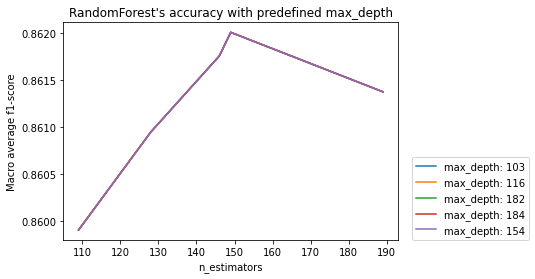

In [20]:
from utils.plot_utils import plot_score

macro_avg_f1_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['macro avg']['f1-score'][0],
                   'std': all_reports[z]['macro avg']['f1-score'][1]}),
    all_reports
))

plot_score(
    [macro_avg_f1_scores],
    ('n_estimators', 'max_depth'),
    'RandomForest',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Macro Average F1-Score'
)


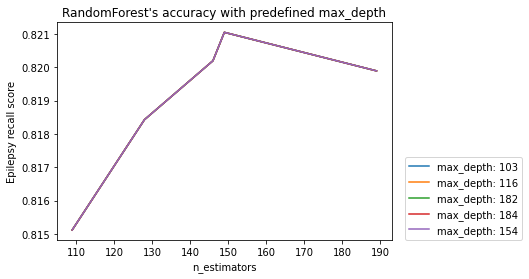

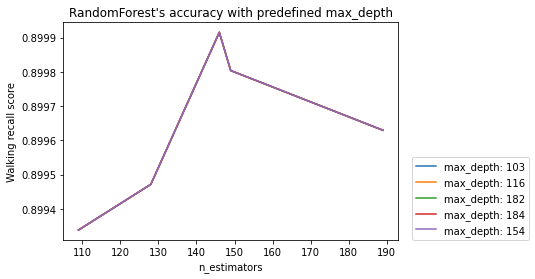

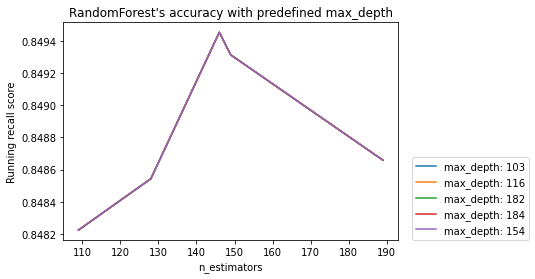

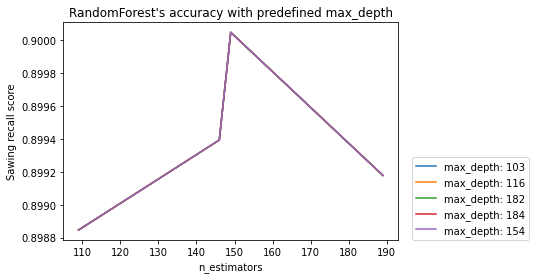

In [21]:
epilepsy_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['epilepsy']['recall'][0],
                   'std': all_reports[z]['epilepsy']['recall'][1]}),
    all_reports
))

walking_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['walking']['recall'][0],
                   'std': all_reports[z]['walking']['recall'][1]}),
    all_reports
))

running_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['running']['recall'][0],
                   'std': all_reports[z]['running']['recall'][1]}),
    all_reports
))

sawing_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['sawing']['recall'][0],
                   'std': all_reports[z]['sawing']['recall'][1]}),
    all_reports
))

plot_score(
    [epilepsy_recall_scores],
    ('n_estimators', 'max_depth'),
    'RandomForest',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Epilepsy recall score'
)

plot_score(
    [walking_recall_scores],
    ('n_estimators', 'max_depth'),
    'RandomForest',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Walking recall score'
)

plot_score(
    [running_recall_scores],
    ('n_estimators', 'max_depth'),
    'RandomForest',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Running recall score'
)

plot_score(
    [sawing_recall_scores],
    ('n_estimators', 'max_depth'),
    'RandomForest',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Sawing recall score'
)


## <font color=#cd0000> Evaluación sobre el conjunto de validación </font>
- Vamos a llevar a cabo la evaluación final sobre el conjunto de validación (esto es lo que irá al apartado de ``Pruebas y Resultados`` de la memoria).

### <font color=#cd0000> Entrenamiento </font>

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=149,
    max_depth=182,
    class_weight=class_weights,
    random_state=SEED
)
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight={'epilepsy': 1.0073529411764706,
                                     'running': 0.9513888888888888,
                                     'sawing': 1.1416666666666666,
                                     'walking': 0.9256756756756757},
                       max_depth=182, n_estimators=149, random_state=1)

### <font color=#cd0000> Clasificación </font>

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
y_true = np.asarray(y_test)
    
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, zero_division=0))


[[5649  424  337  526]
 [ 347 6582  388  231]
 [  79  371 5560  110]
 [ 445  290  110 6703]]
              precision    recall  f1-score   support

    epilepsy       0.87      0.81      0.84      6936
     running       0.86      0.87      0.87      7548
      sawing       0.87      0.91      0.89      6120
     walking       0.89      0.89      0.89      7548

    accuracy                           0.87     28152
   macro avg       0.87      0.87      0.87     28152
weighted avg       0.87      0.87      0.87     28152



# <font color=#cd0000> Conclusiones </font>
- Como ya observábamos tras la aplicación de las codificaciones anteriores, el buen desempeño de esta codificación sobre este clasificador viene dada porque damos información extra relativa a las muestras siguientes que, en un conjunto de datos donde la variabilidad de las clases es un elemento característico de estas, influye significativamente a la hora de clasificarlas.